<a href="https://colab.research.google.com/github/kuprel/min-dalle/blob/main/min_dalle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# min(DALL·E)

### Install

In [1]:
!nvidia-smi
!pip install min-dalle

Fri Aug 12 07:44:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:26:00.0  On |                  N/A |
|  0%   54C    P8    38W / 215W |   2265MiB /  7974MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load Model
`float32` is faster than `float16` but uses more GPU memory.

In [2]:
dtype = "bfloat16" #@param ["float32", "float16", "bfloat16"]
from IPython.display import display, update_display
import torch
from min_dalle import MinDalle
!rm -rf pretrained
exit()
model = MinDalle(
    dtype=getattr(torch, dtype),
    device=None,  # "cuda" if torch.cuda.is_available() else "cpu",
    is_mega=True,
    is_reusable=True,
    load_encoder=False
)

using device cuda
downloading tokenizer params
intializing TextTokenizer
downloading decoder params
initializing DalleBartDecoder
downloading detokenizer params
initializing VQGanDetokenizer


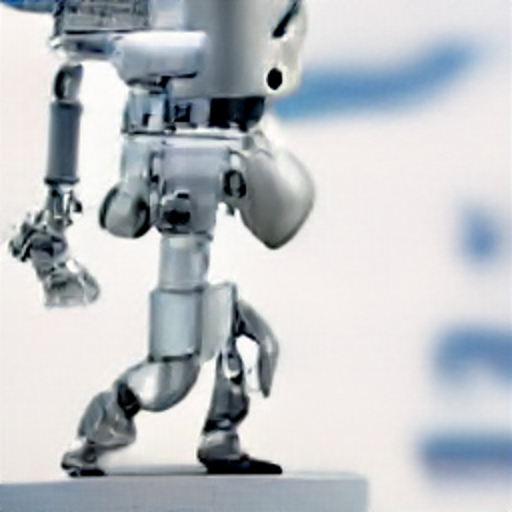

In [3]:
#@title Tune DALL-E mini
from PIL import Image
import requests
import io
import os


download = lambda x: Image.open(io.BytesIO(requests.get(x).content))
#@markdown Image URL. Leave empty if you upload your own
url = "" #@param ["https://manekens.ru/storage/app/uploads/public/34/5d25eabf21090114407732.jpg", ""] {allow-input: true}
#@markdown (Optional) image path if you upload your own
path = "generated.png"  #@param {type: "string"}
if len(url):
    target = download(url)
else:
    if not os.path.exists(path):
        from google.colab import files
        print("Upload image:")
        uploaded = list(files.upload())
        if uploaded:
            path = uploaded[0]
        else:
            print("Please upload something. Erroring out soon...")
    target = Image.open(path)
target = target.convert("RGB").resize((512, 512))
target

In [ ]:
!pip install taming-transformers
!curl -L -o vqgan_imagenet_f16_1024.yaml -C - "https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1"
!curl -L -o vqgan_imagenet_f16_1024.ckpt -C - "https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1"

In [ ]:
%%file vqgan_imagenet_f16_1024.yaml
model:
  base_learning_rate: 4.5e-06
  target: taming.models.vqgan.VQModel
  params:
    ckpt_path: vqgan_imagenet_f16_1024.ckpt
    embed_dim: 256
    n_embed: 1024
    ddconfig:
      double_z: false
      z_channels: 256
      resolution: 256
      in_channels: 3
      out_ch: 3
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      num_res_blocks: 2
      attn_resolutions:
      - 16
      dropout: 0.0
    lossconfig:
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
      params:
        disc_conditional: false
        disc_in_channels: 3
        disc_start: 0
        disc_weight: 0.8
        codebook_weight: 1.0
        


In [ ]:
from omegaconf import OmegaConf
from taming.models import vqgan as vq


def load_vqgan_model(config_path):
    config = OmegaConf.load(config_path)
    checkpoint_path = config.model.params.ckpt_path
    if config.model.target == "taming.models.vqgan.VQModel":
        model = vq.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == "taming.models.vqgan.GumbelVQ":
        model = vq.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
        gumbel = True
    elif config.model.target == "taming.models.cond_transformer.Net2NetTransformer":
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f"unknown model type: {config.model.target}")
    del model.loss
    return model


vqgan = load_vqgan_model("vqgan_imagenet_f16_1024.yaml").to(model.device)

In [ ]:
from matplotlib import pyplot as plt
import torchvision.transforms as T
import numpy as np
import random


def preprocess_vqgan(x):
    x = 2. * x - 1.
    return x

def custom_to_pil(x):
    x = np.clip(x, -1., 1.)
    x = (x + 1.)/2.
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def preprocess(img, target_image_size=256,):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f"min dim for image {s} < {target_image_size}")
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = T.functional.resize(img, s, interpolation=Image.LANCZOS)
    img = T.functional.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img.permute(0, 2, 3, 1).numpy()


@torch.no_grad()
def decode(code, cols=4):
    vqgan.quantize.embed_code = lambda x: vqgan.quantize.get_codebook_entry(
        x.flatten().long(),
        (x.shape[0], 16, 16, -1))
    pic = vqgan.decode_code(code).permute(0, 2, 3, 1).cpu().detach().numpy()
    height = (len(code) - 1) // cols + 1
    plt.figure(figsize=(8, 2 * height), dpi=150)
    plt.axis("off")
    plt.imshow(np.concatenate([np.concatenate([pic[y * cols + x]
                                               if y * cols + x < len(pic)
                                               else pic[0] * 0
                                               for x in range(cols)],
                                              axis=1)
                               for y in range(height)], axis=0))
    plt.show()


enc = vqgan.encode(torch.from_numpy(preprocess(target, 256)).to(model.device)
                   .permute(0, 3, 1, 2))[-1][-1].T
decode(enc)

In [ ]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [ ]:
#@markdown Make this higher for more similarity, lower for faster training or more abstraction
n_embeds =   12#@param {type: "integer"}
#@markdown Parameter for stability, try not to change this
init_scale =   1e-2#@param {type: "number"}

#@markdown Random seed, 0 for no seed
seed = 12  #@param {type: "integer"}
if seed == 0:
    seed = random.getrandbits(16)
print("Seed:", seed)
torch.manual_seed(seed)
model.decoder.requires_grad_(False)
torch.set_grad_enabled(True)
t = torch.nn.Parameter(torch.randn((1, n_embeds, model.embed_count),
                                   device=model.device, dtype=getattr(torch, dtype)) *
                       init_scale, requires_grad=True)

#@markdown Maximum learning rate
lr = 1e-2  #@param {type: "number"}
optim = torch.optim.Adam([t], lr=lr)

In [ ]:
#@title Perform training
from IPython.display import display, clear_output
from ipywidgets import Output
from tqdm.auto import trange


#@markdown Learning time, make this lower if you want more abstraction
n_iterations =   150#@param {type: "integer"}
display_rate =   8#@param {type: "integer"}
gradient_clip_norm =   10.0#@param {type: "number"}
bar = trange(n_iterations)
out = Output()
display(out)
logs = []
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, n_iterations * 2,
                                                       eta_min=1e-4)
try:
    for i in bar:
        optim.zero_grad()
        sl = model.decoder.embed_positions.num_embeddings  # No thank you for hardcoding IMAGE_TOKEN_COUNT
        logits, _ = model.decoder(attention_mask=torch.ones((1, sl), device=model.device, dtype=getattr(torch, dtype)), encoder_state=t.repeat(2, 1, 1),
                                  prev_tokens=enc, attention_state=[None for _ in range(model.layer_count)], token_index=torch.arange(sl, device=model.device, dtype=torch.long))
        logits = torch.nn.functional.log_softmax(logits, dim=-1)
        loss = torch.nn.functional.cross_entropy(logits[0, :-1], enc[0, 1:])
        loss.backward()
        torch.nn.utils.clip_grad_norm_([t], gradient_clip_norm)
        optim.step()
        bar.set_description(f"loss: {loss.item()}")
        logs.append(loss.item())
        if i % display_rate == display_rate - 1:
            with out:
                clear_output()
                plt.plot(logs)
                plt.show()
except KeyboardInterrupt:
    print("Early stopping...")

### Generate Images

- `grid_size` Size of the image grid.  Reduce this if you run out of GPU memory.

- `progressive_outputs` Whether to show intermediate output.  Adds a small delay and increases memory usage.

- `seamless` Tiles the images in token space instead of pixel space

- `supercondition_factor` Higher values result in better agreement with the text but a narrower variety of generated images

- `top_k` Each image token is sampled from the top $k$ most probable tokens

In [ ]:
%%time

text = "Dali painting of WALL·E" #@param {type:"string"}
progressive_outputs = True #@param {type:"boolean"}
seamless = False #@param {type:"boolean"}
grid_size = 3 #@param {type:"integer"}
temperature = 1 #@param {type:"slider", min:0.01, max:16, step:0.01}
supercondition_factor = 16 #@param {type:"number"}
top_k = 128 #@param {type:"integer"}

image_stream = model.generate_image_stream(
    text=text,
    seed=-1,
    grid_size=grid_size,
    progressive_outputs=progressive_outputs,
    is_seamless=seamless,
    temperature=temperature,
    top_k=int(top_k),
    supercondition_factor=float(supercondition_factor)
)

is_first = True
for image in image_stream:
    display_image = display if is_first else update_display
    display_image(image, display_id=1)
    is_first = False